# Evaluate trained PINN models

In [1]:
import numpy as np
import pandas as pd
import torch.nn as nn
import torch
import scipy
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm import tqdm

from src.model import NavierStokesPINN1, NavierStokesPINNLoss1
from src.model import NavierStokesPINN2, NavierStokesPINNLoss2
from src.load_cynlinder_wake import load_cylinder_wake

In [2]:
# Load flattened cynlinder wake data
x_all, y_all, t_all, u_all, v_all, p_all, (N, T) = load_cylinder_wake() # (NT, 1)

# Separate N and T dimensions
XX = x_all.reshape(N, T)
YY = y_all.reshape(N, T)
TT = t_all.reshape(N, T)
UU = u_all.reshape(N, T)
VV = v_all.reshape(N, T)
PP = p_all.reshape(N, T)

# For example, XX[:, [0]].reshape(50, 100) is the the grid of x-coordinates at the first timestep
# (50, 100) is the size of the original simulation grid

In [3]:
def load_saved_model(num_layers, hidden_size, epochs, model, train_selection):
    """ 
    Params:
    hidden_size - int, # of hidden units for each neural network layer
    num_layers - int, # of neural network layers
    epochs - int, # of training epochs
    model - int, whether to use model 1 (Raissi 2019) or model 2 (continuity PDE)
    train_selection - data selection scheme at training time:
                    float, frac of all data (N*T) to selected for training OR 
                    'BC', selected the boundary conditions for training (all timesteps)
    """
    nu = 0.01
    rho = 1

    # Instantiate model, load saved state_dict
    torch.manual_seed(0)
    if model == 1:
        PINN_model = NavierStokesPINN1(hidden_size=hidden_size, num_layers=num_layers, nu=nu, rho=rho)
    elif model ==2:
        PINN_model = NavierStokesPINN2(hidden_size=hidden_size, num_layers=num_layers, nu=nu, rho=rho)

    PINN_model.load_state_dict(torch.load(f'data/model{model}_{num_layers}l_{hidden_size}h_{epochs}e_{train_selection}d.pt'))
    PINN_model.eval() # Set model to evaluation mode
    return PINN_model

In [4]:
def predict_time_t(model, t):
    """ 
    Evaluate the model at time t, i.e., at TT[:, [t]]
    Params:
    model - PyTorch model to evaluate
    t - int between 0 and T-1, time index to evaluate
    Return:
    np.array() of shape (N, )
    """
    # Get predictions timestep t
    model_output = model(XX[:, [t]], YY[:, [t]], TT[:, [t]])
    u_pred, v_pred, p_pred = model_output[0], model_output[1], model_output[2]

    # Convert to numpy and flatten
    u_pred, v_pred, p_pred = (u_pred.detach().numpy().flatten(), 
                            v_pred.detach().numpy().flatten(),
                            p_pred.detach().numpy().flatten())
    return u_pred, v_pred, p_pred

## Visualize PINN vs. reference flow field

In [5]:
def contourf_subplots(vel, vel_pred, p, p_pred, range_dict, axes):
    """
    Create subplots of contourf plots for predicted and reference velocity (magnitude) and pressure
    Params:
    vel, vel_pred, p, p_pred - np.array of shape (N, ), reference and predicted velocity magnitude and pressure
    range_dict - dict with keys 'vel' and 'p' containing tuples (vmin, vmax) for contour value ranges
    axes - axes to plot on. (3, 2) if rmse is included, (2, 2) otherwise
    """

    # Plot prediction contours
    axes[0, 0].set_title('Predicted velocity magnitude')
    contour_vel_pred = axes[0, 0].contourf(vel_pred.reshape(50, 100), levels=30, cmap='jet',
                                           vmin=range_dict['vel'][0], vmax=range_dict['vel'][1])
    
    axes[0, 1].set_title('Predicted pressure')
    contour_p_pred = axes[0, 1].contourf(p_pred.reshape(50, 100), levels=30, cmap='jet',
                                         vmin=range_dict['p'][0], vmax=range_dict['p'][1])

    # Plot DNS reference contours
    axes[1, 0].set_title('Reference velocity magnitude')
    contour_vel = axes[1, 0].contourf(vel.reshape(50, 100), levels=30, cmap='jet',
                                      vmin=range_dict['vel'][0], vmax=range_dict['vel'][1])

    axes[1, 1].set_title('Reference pressure')
    contour_p = axes[1, 1].contourf(p.reshape(50, 100), levels=30, cmap='jet',
                                    vmin=range_dict['p'][0], vmax=range_dict['p'][1])
        
    return [contour_vel, contour_vel_pred, contour_p, contour_p_pred]

In [6]:
def plot_flow_field(model, title=''):
    """ 
    Params:
    model - PyTorch model to evaluate
    """
    # Set up plot
    fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize=(10, 6), sharex=True, sharey=True)

    # Get predictions at first timestep
    u_pred_0, v_pred_0, p_pred_0 = predict_time_t(model=model, t=0) # Each of shape (N, )

    # Predicted and reference velocity magnitude at first timestep
    vel_pred_0, vel_0 = np.sqrt(u_pred_0 ** 2 + v_pred_0 ** 2), np.sqrt(UU[:, 0] ** 2 + VV[:, 0] ** 2)
    
    # Max/min predicted OR reference velocity and pressure (for colorbar)
    max_vel, min_vel = np.concatenate([vel_0, vel_pred_0]).max(), np.concatenate([vel_0, vel_pred_0]).min()
    max_p, min_p = np.concatenate([PP[:, 0], p_pred_0]).max(), np.concatenate([PP[:, 0], p_pred_0]).min()
    range_dict = {'vel':(min_vel, max_vel), 'p':(min_p, max_p)} # dict for contourf_suplots function

    # Initial contour subplot at first timestep
    contours_0 = contourf_subplots(vel_0, vel_pred_0, PP[:, 0], p_pred_0, range_dict=range_dict, axes=axes)

    # Create figure labels, colobar
    fig.colorbar(contours_0[0], ax=[axes[0, 0], axes[1, 0]], orientation='vertical', shrink=0.45)
    fig.colorbar(contours_0[2], ax=[axes[0, 1], axes[1, 1]], orientation='vertical', shrink=0.45)
    fig.supxlabel(r'$x$')
    fig.supylabel(r'$y$')
    fig.suptitle(title)

    # Animate future timesteps
    def animate(i):
        [ax.clear() for ax in axes.flatten()]

        # Get predictions at timestep i
        u_pred_i, v_pred_i, p_pred_i = predict_time_t(model=model, t=i) # each of shape (N, )
        
        # Predicted and reference velocity magnitude at timestep i
        vel_pred_i, vel_i = np.sqrt(u_pred_i ** 2 + v_pred_i ** 2), np.sqrt(UU[:, i] ** 2 + VV[:, i] ** 2)        

        # Contourf subplots at timestep i
        contours_i = contourf_subplots(vel_i, vel_pred_i, PP[:, [i]], p_pred_i, range_dict=range_dict, axes=axes)

    ani = animation.FuncAnimation(fig, animate, 40, interval=1, blit=False)
    return ani

### Model 2: 5 layers, 30 hidden units, 5000 epochs

In [20]:
# Load model
model2_5l_30h_5000e = load_saved_model(num_layers=5, hidden_size=30, epochs=5000, model=2, train_selection=0.005)

# Plot flow field
%matplotlib notebook
ani = plot_flow_field(model2_5l_30h_5000e)
# ani.save('figures/ref_vs_pred_model2_5l_30h_5000e_0.005d.gif')
from IPython.display import HTML
HTML(ani.to_jshtml())

<IPython.core.display.Javascript object>

MovieWriter ffmpeg unavailable; using Pillow instead.


## Root mean square error
Comparing root-mean-square error between the neural network prediction and the reference DNS

In [10]:
def plot_rmse_field(model, title=''):
    """ 
    Params:
    PyTorch model to evaluate
    """
    fig, axes = plt.subplots(ncols = 2, figsize=(11, 5), sharex=True, sharey=True)

    # Get predictions at t=0
    u_pred_0, v_pred_0, p_pred_0 = predict_time_t(model=model, t=0)
    
    # Predicted and reference velocity magnitude
    vel_pred_0, vel_0 = np.sqrt(u_pred_0 ** 2 + v_pred_0 ** 2), np.sqrt(UU[:, 0] ** 2 + VV[:, 0] ** 2)

    # Calculate RMSE
    v_rmse_0, p_rmse_0 = np.sqrt(((vel_pred_0 - vel_0) ** 2)), np.sqrt(((p_pred_0 - PP[:, 0]) ** 2))
    
    # Initial plot
    contour_vel = axes[0].contourf(v_rmse_0.reshape(50, 100), levels=30, cmap='jet')
    contour_p = axes[1].contourf(p_rmse_0.reshape(50, 100), levels=30, cmap='jet')

    # Create figure labels, colorbar
    fig.colorbar(contour_vel, ax=axes[0], orientation='vertical', shrink=0.45)
    fig.colorbar(contour_p, ax=axes[1], orientation='vertical', shrink=0.45)
    fig.supxlabel(r'$x$')
    fig.supylabel(r'$y$')
    fig.suptitle(title)

    # Animate future timesteps
    def animate(i):
        [ax.clear() for ax in axes.flatten()]

        # Get predictions at timestep i
        u_pred_i, v_pred_i, p_pred_i = predict_time_t(model=model, t=i)
        
        # Predicted and reference velocity magnitude
        vel_pred_i, vel_i = np.sqrt(u_pred_i ** 2 + v_pred_i ** 2), np.sqrt(UU[:, i] ** 2 + VV[:, i] ** 2)

        # Calculate RMSE
        v_rmse, p_rmse = np.sqrt(((vel_pred_i - vel_i) ** 2)), np.sqrt(((p_pred_i - PP[:, i]) ** 2))

        # Plot rmse at timestep i
        axes[0].set_title('Velocity magnitude RMSE')
        contour_vel_pred = axes[0].contourf(v_rmse.reshape(50, 100), levels=30, cmap='jet')
        axes[1].set_title('Pressure RMSE')
        contour_p_pred = axes[1].contourf(p_rmse.reshape(50, 100), levels=30, cmap='jet')

    ani = animation.FuncAnimation(fig, animate, 40, interval=1, blit=False)
    return ani

In [11]:
# Load model
model2_5l_30h_5000e = load_saved_model(num_layers=5, hidden_size=30, epochs=5000, model=2, train_selection=0.005)

# Plot flow field
%matplotlib notebook
ani = plot_rmse_field(model2_5l_30h_5000e)
ani.save('figures/rmse_evolution.gif')
from IPython.display import HTML
HTML(ani.to_jshtml())

<IPython.core.display.Javascript object>

MovieWriter ffmpeg unavailable; using Pillow instead.


In [7]:
def rMSE(model):
    """ 
    Calculate root mean square error between the predictions and the DNS, over all data points (N) and all timesteps (T)
    Params:
    model - trained PINN model to evaluate
    x_all, y_all, t_all - array of shape (NT, 1) representing x, y, and t coordinates for each data point and timestep 
    u_all, v_all, p_all - array of shape (NT, 1) representing reference x-vel, y-vel, and pressure
    Returns:
    rmse - array of shape (3, ) containing rmse for x-vel (u), y-vel (v), and pressure (p), respectively
    R2 - array of shape (3, ) containing corresponding R2 scores 
    """
    # Initialize array to hold sum of square errors (SSE)
    sse = np.zeros((T, 3))

    for i in range(T):
        # Get predictions for time i
        u_pred, v_pred, p_pred = predict_time_t(model, t=i)
        # Save sum of square errors for time i
        sse[i, :] = [((u_pred - UU[:, i]) ** 2).sum(),
                     ((v_pred - VV[:, i]) ** 2).sum(),
                     ((p_pred - PP[:, i]) ** 2).sum()]
        
    # Sum sse over timesteps
    sse = sse.sum(axis=0) # (3, )
    # Average sse over all samples and all timesteps to get mse
    mse = sse / (N * T)

    # Find total sum of squares (SSTO)
    ssto = np.array([((u_all - u_all.mean()) ** 2).sum(), ((v_all - v_all.mean()) ** 2).sum(), ((p_all - p_all.mean()) ** 2).sum()])
    R2 = 1 - (sse / ssto)

    return np.sqrt(mse), R2

In [8]:
# Calcualte rmse for each epoch
epoch_list = [50, 200, 1000, 5000, 20000]
model_list = [load_saved_model(5, 30, epochs=epoch, model=2, train_selection=0.005) for epoch in epoch_list]
rmse_list, r2_list = [], []
for i, epoch in enumerate(epoch_list):
    rmse_i, r2_i = rMSE(model_list[i]) #each of shape (3, )
    rmse_list.append(rmse_i)
    r2_list.append(r2_i)

rmse, r2 = np.vstack(rmse_list), np.vstack(r2_list) # (# epochs tested, [u, v, p])
rmse_df, r2_df = pd.DataFrame(rmse, columns=['u', 'v', 'p'], index=epoch_list), pd.DataFrame(r2, columns=['u', 'v', 'p'], index=epoch_list)

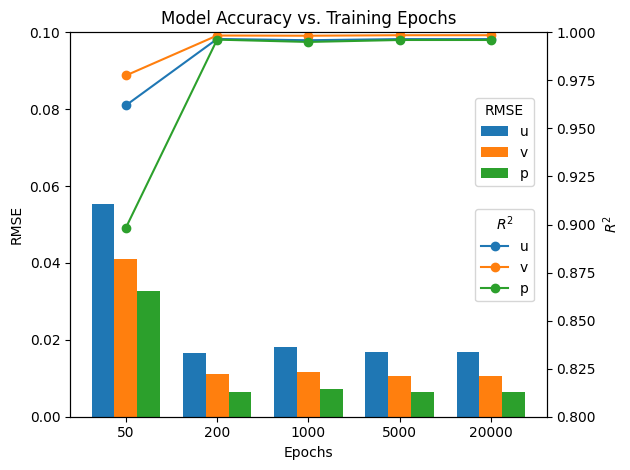

In [9]:
%matplotlib inline
fig, ax1 = plt.subplots()

x = np.arange(len(epoch_list))  # the label locations
width = 0.25  # the width of the bars

# Plot RMSE
ax1.bar(x - width, rmse_df['u'], width=width, label='u')
ax1.bar(x, rmse_df['v'], width=width, label='v')
ax1.bar(x + width, rmse_df['p'], width=width, label='p')

# Plot R2
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(x, r2_df['u'], label='u', marker='o')
ax2.plot(x, r2_df['v'], label='v', marker='o')
ax2.plot(x, r2_df['p'], label='p', marker='o')
ax2.set_ylim(bottom=0.8, top=1.0)

ax1.legend(loc=(0.85, 0.6), title='RMSE')
ax2.legend(loc=(0.85, 0.3), title='$R^2$')
ax1.set_ylim(bottom=0, top=0.1)
ax1.set_xticks(x, epoch_list)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('RMSE')
ax2.set_ylabel('$R^2$')
ax1.set_title('Model Accuracy vs. Training Epochs')
plt.tight_layout()
plt.savefig('figures/accuracy_vs_epochs.png')
plt.show()